In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [66]:
from google.colab import files
up = files.upload()
import pandas as pd, os
print(os.listdir())
df = pd.read_csv("Ionosphere.csv")

Saving Ionosphere.csv to Ionosphere.csv
['.config', 'Ionosphere.csv', '04-LinearReg_Salary.csv', 'sample_data']


In [70]:
label_col = df.columns[-1]

y_raw = df[label_col].astype(str).str.strip().str.lower()

map_dict = {"g": 1, "good": 1, "1": 1, "b": 0, "bad": 0, "0": 0}
y = y_raw.map(map_dict)

unmapped = y_raw[y.isna()].unique()
print("Unmapped labels (if any):", unmapped)

if y.isna().any():
    y, label_index = pd.factorize(y_raw)
    print("Used factorize. Label mapping:", dict(enumerate(label_index)))

X = df.drop(columns=[label_col]).apply(pd.to_numeric, errors="coerce")
mask = ~X.isna().any(axis=1)
X, y = X[mask], np.asarray(y)[mask]

print("Shapes after cleaning -> X:", X.shape, " y:", y.shape)
print("y value counts:\n", pd.Series(y).value_counts())

Unmapped labels (if any): []
Shapes after cleaning -> X: (351, 34)  y: (351,)
y value counts:
 1    225
0    126
Name: count, dtype: int64


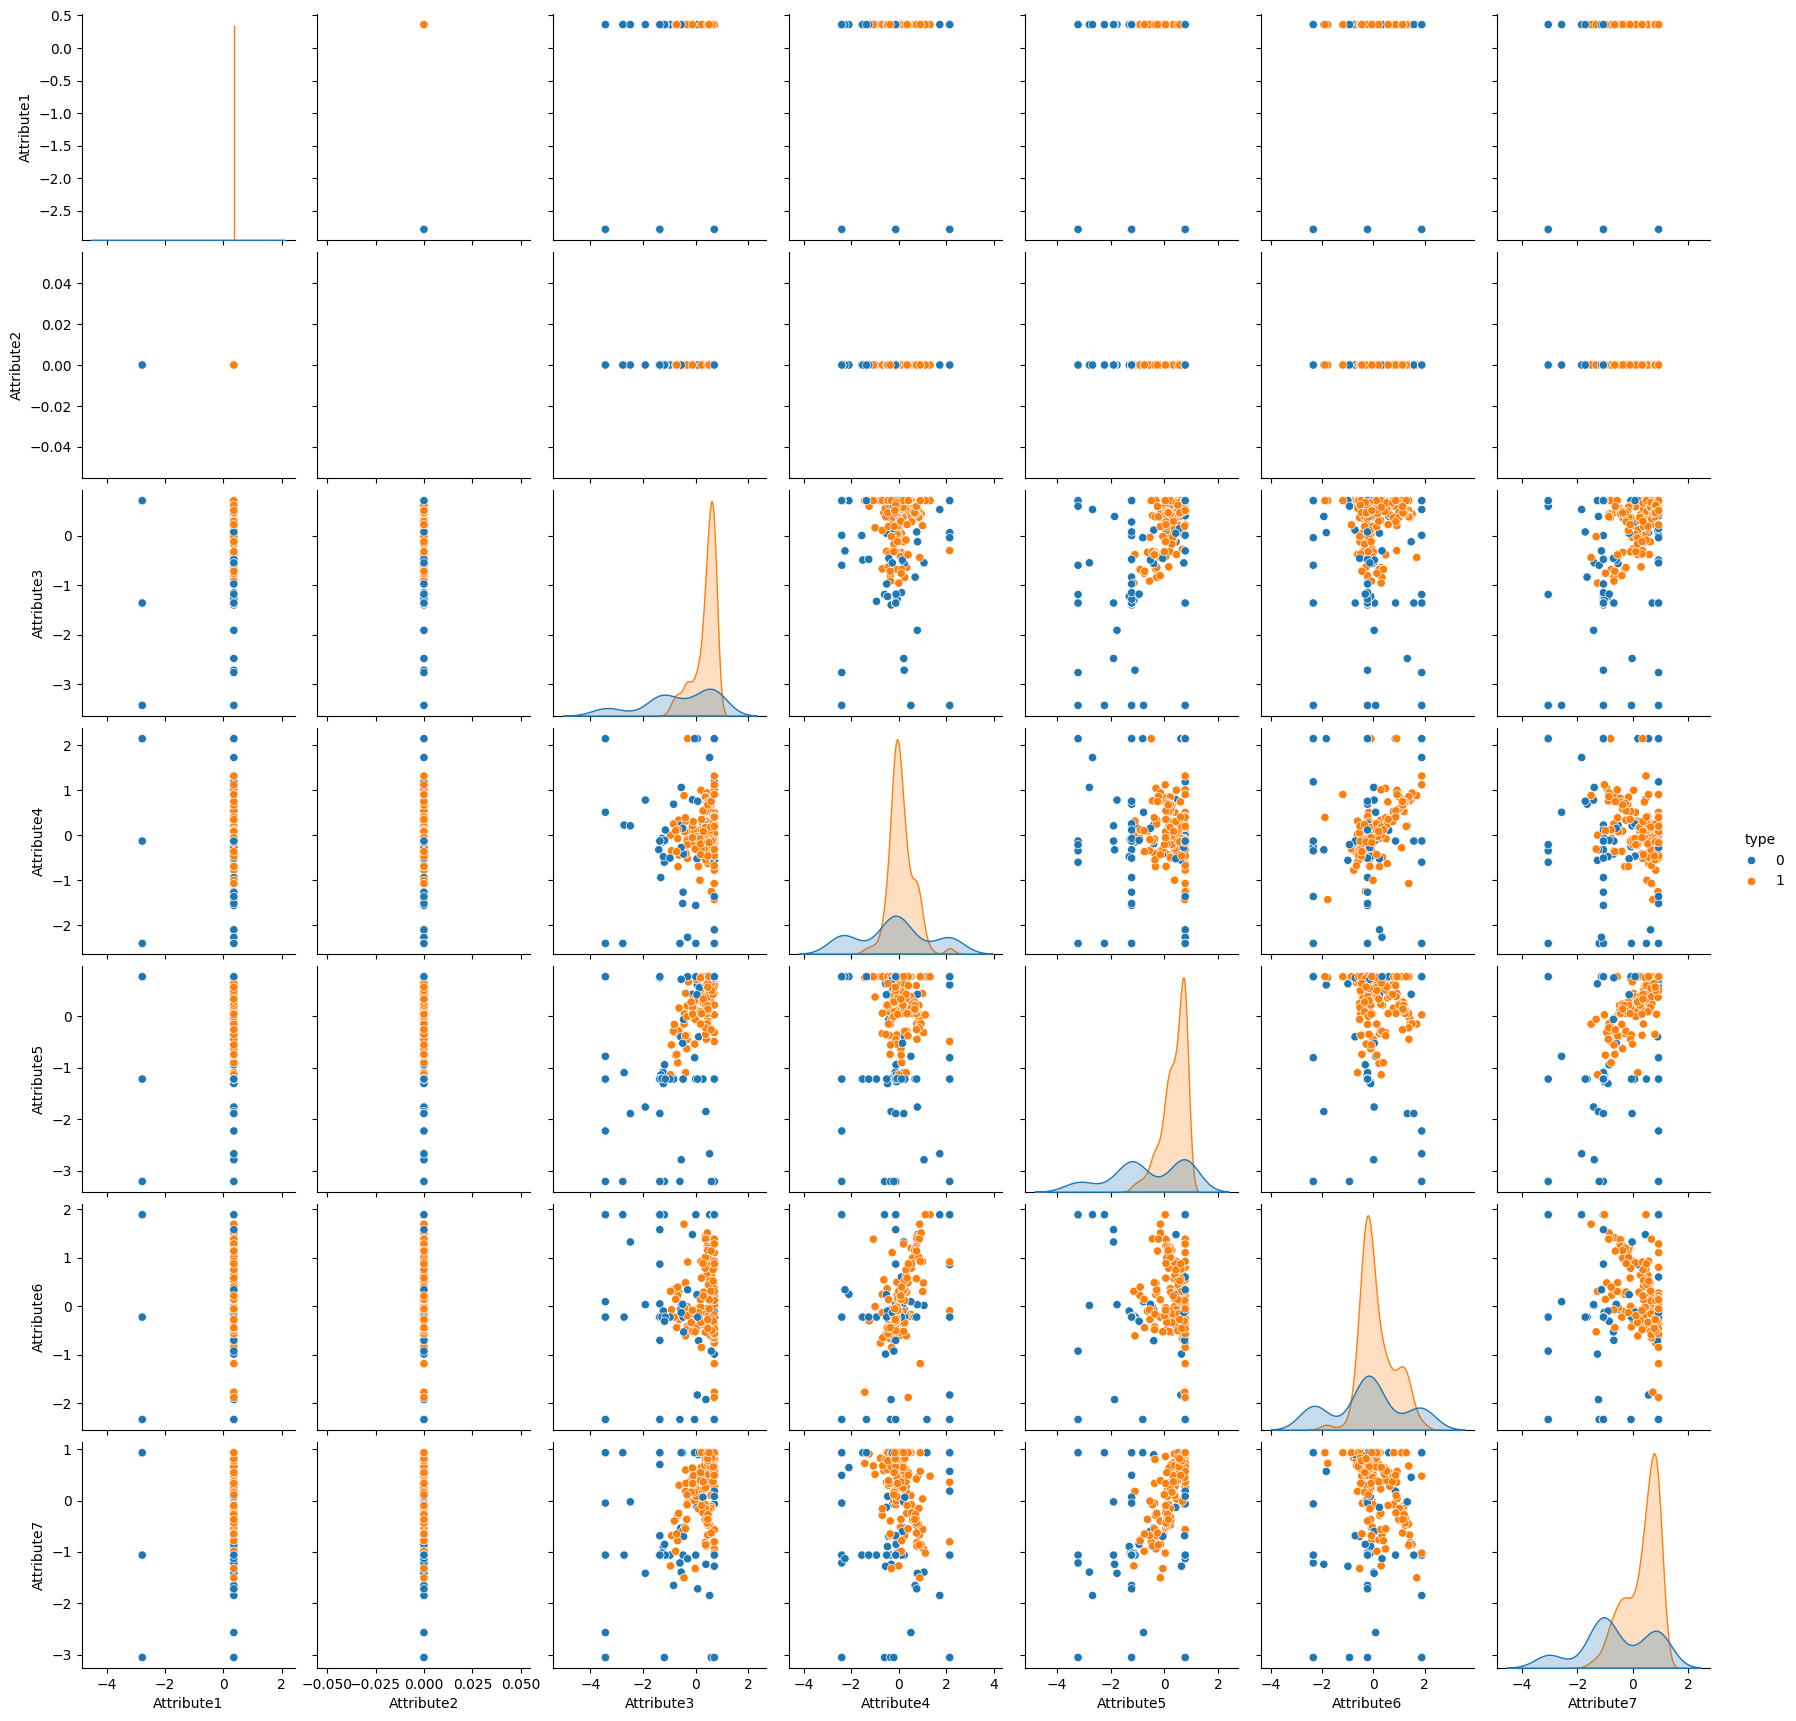

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

feature_names = list(df.columns[:-1]) if "class" not in df.columns else [c for c in df.columns if c != "class"]
plot_df = pd.DataFrame(X_train, columns=feature_names)

plot_df = plot_df.iloc[:, :7].copy()

plot_df["type"] = pd.Series(y_train).astype(int)

sns.pairplot(plot_df, hue="type")
plt.show()

In [73]:
cols = [2, 7]
X2_train = X_train[:, cols]
y2_train = y_train
X2_test  = X_test[:, cols]
y2_test  = y_test

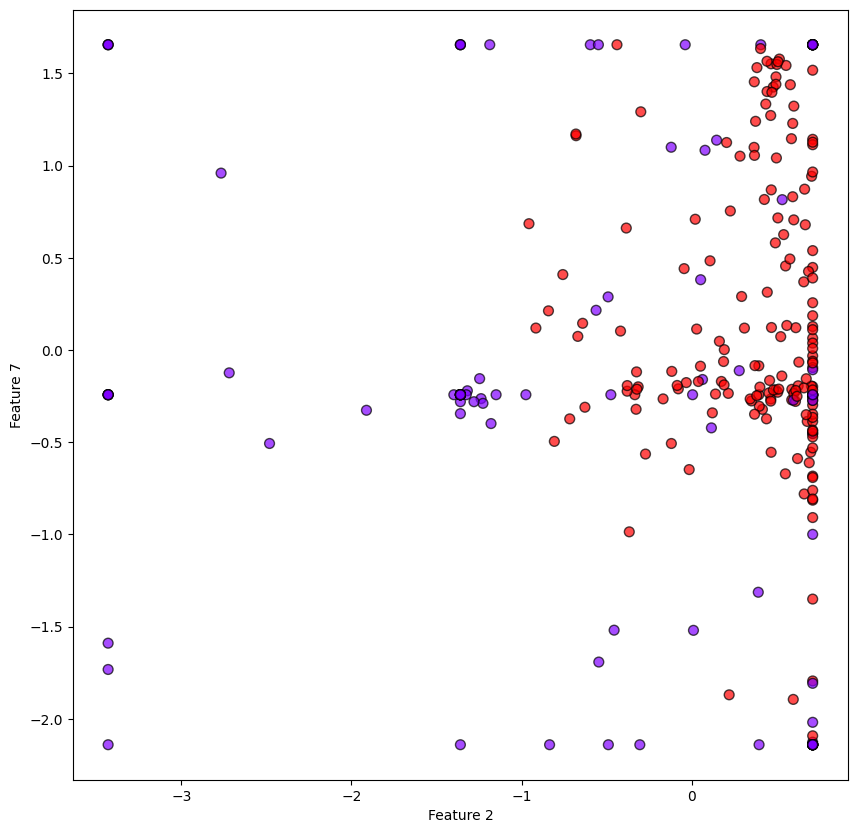

In [74]:
plt.figure(figsize=(10,10))
plt.scatter(X2_train[:,0], X2_train[:,1], c=y2_train, cmap='rainbow', edgecolors='k', s=50, alpha=0.7)
plt.xlabel(f"Feature {cols[0]}")
plt.ylabel(f"Feature {cols[1]}")
plt.show()

In [79]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

class LogRegSimple():
    def __init__(self, lr=0.1, n_epoch=100):
        self.lr = lr
        self.n_epoch = n_epoch
        self.weights = None
        self.bias = None

    def __forward__(self, X):
        return sigmoid(np.dot(X, self.weights) + self.bias)

    def fit(self, X, y):
        self.weights = np.array([0, 0])
        self.bias = 0

        for epoch in range(self.n_epoch):
            y_pred = self.__forward__(X)
            loss = (np.dot(-y, np.log(y_pred)) - np.dot(1-y, np.log(1-y_pred))) / X.shape[0]

            self.weights = self.weights + self.lr * np.dot(X.T, (y - y_pred)) / X.shape[0]
            self.bias = self.bias + self.lr * (y - y_pred).mean()

        return self

    def predict(self, X):
        return self.__forward__(X).round()

    def param(self):
        return self.weights, self.bias

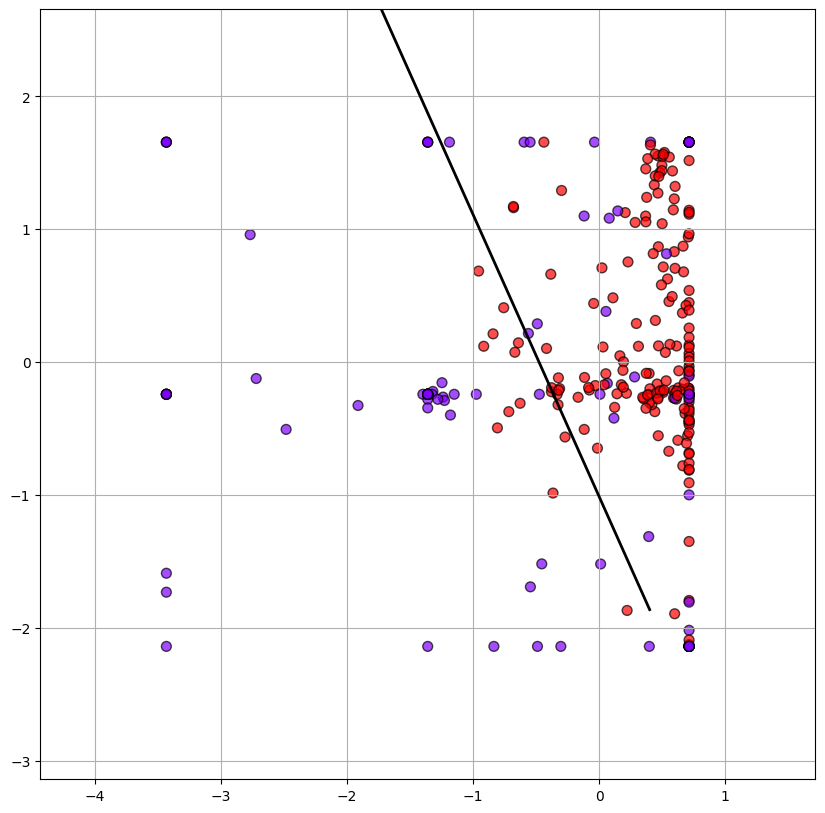

In [78]:
model = LogRegSimple(lr=0.1, n_epoch=200)
model.fit(X2_train, y2_train)

w, b = model.weights, model.bias

xx = np.arange(-2.5, 0.5, 0.1)
yy = ( - (w[0] * xx + b) / w[1] )

plt.figure(figsize=(10,10))
plt.scatter(X2_train[:,0], X2_train[:,1], c=y2_train, cmap='rainbow',
            edgecolors='k', s=50, alpha=0.7)

plt.plot(xx, yy, linewidth=2, c='k')

plt.xlim([X2_train[:,0].min()-1, X2_train[:,0].max()+1])
plt.ylim([X2_train[:,1].min()-1, X2_train[:,1].max()+1])

plt.grid()
plt.show()

In [77]:
def plot_decision_boundary(X, y, model, resolution=0.02):
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    cmap = ListedColormap(colors[:len(np.unique(y))])
    markers = ['s', 'x', 'o', '^', 'v']

    x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
    y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx.min(), xx.max()); plt.ylim(yy.min(), yy.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(X[y == cl, 0], X[y == cl, 1],
                    c=[cmap(idx)], edgecolors='k', marker=markers[idx],
                    label=str(cl), s=50)

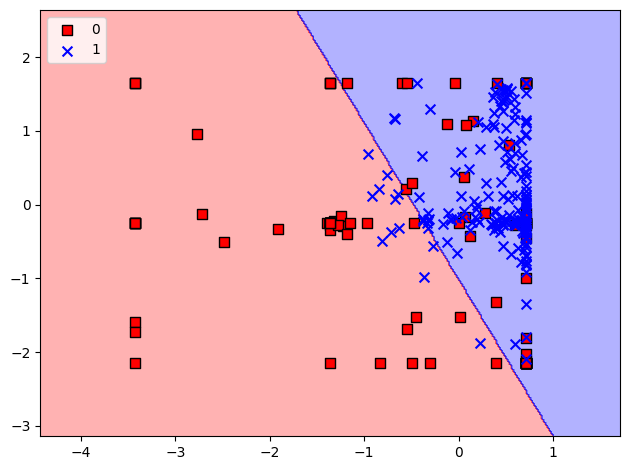

In [80]:
plot_decision_boundary(X2_train, y2_train, model)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

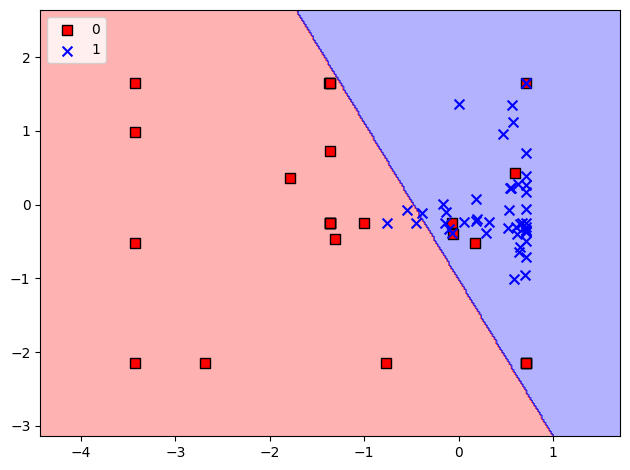

In [81]:
plot_decision_boundary(X2_test, y2_test, model)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [82]:
y_test_pred=model.predict(X2_test)
confusion_matrix(y2_test,y_test_pred)

array([[17,  8],
       [ 3, 43]])

In [86]:
SKLLogReg = LogisticRegression(random_state=42)
SKLLogReg.fit(X2_train, y2_train)

predictions = SKLLogReg.predict(X2_test)
print(confusion_matrix(y2_test, predictions))

[[17  8]
 [ 4 42]]


In [87]:
SKLLogReg2 = SGDClassifier(
    loss='log_loss',
    max_iter=200,
    learning_rate='constant',
    eta0=0.1,
    random_state=42
)
SKLLogReg2.fit(X2_train, y2_train)

predictions = SKLLogReg2.predict(X2_test)
print(confusion_matrix(y2_test, predictions))

[[17  8]
 [ 3 43]]


In [88]:
X_train=torch.tensor(X_train, dtype=torch.float)
y_train=torch.tensor(y_train, dtype=torch.float)
X_test=torch.tensor(X_test, dtype=torch.float)
y_test=torch.tensor(y_test, dtype=torch.float)

n_samples, n_features = X_train.shape
y_train=y_train.reshape(-1, 1)
y_test=y_test.reshape(-1,1)

In [89]:
class PTLogisticRegression(nn.Module):
    def __init__(self, n_features):
        super(PTLogisticRegression, self).__init__()
        self.linear= nn.Linear(n_features, 1)
    def forward(self,x):
        y_pred=torch.sigmoid(self.linear(x))
        return y_pred

In [90]:
lr=0.1
n_epoch=100

In [91]:
model=PTLogisticRegression(n_features)

lossfunc=nn.BCELoss()
optimizer=torch.optim.SGD(model.parameters(),lr=lr, weight_decay=0)

In [92]:
train_loss=[]
test_loss=[]


for epoch in range(n_epoch):
    model.train()
    y_pred=model(X_train)
    loss=lossfunc(y_pred, y_train)
    loss.backward()
    train_loss.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()



    model.eval()
    with torch.inference_mode():
        y_test_pred=model(X_test)
        lost_test=lossfunc(y_test_pred, y_test)
        test_loss.append(lost_test)

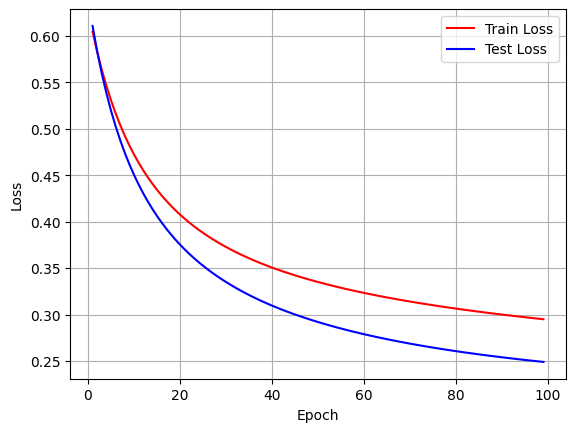

In [93]:
fig=plt.figure()
xv=np.arange(1, n_epoch,1)
plt.plot(xv,train_loss[1:], 'r', label="Train Loss")
plt.plot(xv,test_loss[:-1], 'b', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [94]:
y_test_pred=y_test_pred.round()
confusion_matrix(y_test,y_test_pred)

array([[21,  4],
       [ 0, 46]])